We only work in USD. The initial balance was converted from CAD to USD on day 1.


In [75]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from termcolor import colored

In [76]:
CRYPTO_PATH = "data/crypto/"
cryptoFiles = [
  "BTC-USD.csv",
  "BNB-USD.csv",
  "DOGE-USD.csv",
  "ETH-USD.csv",
  "SOL-USD.csv",
]

crypto_dataframes = {}

for file in cryptoFiles:
  file_path = CRYPTO_PATH + file
  df = pd.read_csv(file_path)

  # Keep only the Date and Close columns
  df = df[["Date", "Close"]]

  # Store the DataFrame in the dictionary
  crypto_dataframes[file.split("-")[0]] = df

In [77]:
START_DATE = "2015-07-01"
END_DATE = "2024-07-31"

BALANCE = 1000  # CAD

USD_TO_CAD_JULY_2015 = 1.261

# Convert the initial balance to USD
BALANCE = BALANCE / USD_TO_CAD_JULY_2015

# Create a new DataFrame to log portfolio values
portfolio_df = pd.DataFrame(
  columns=["Date", "Cash", "BTC", "BNB", "DOGE", "ETH", "SOL"]
)
portfolio_df.loc[len(portfolio_df)] = {
  "Date": START_DATE,
  "Cash": BALANCE,
  "BTC": 0,
  "BNB": 0,
  "DOGE": 0,
  "ETH": 0,
  "SOL": 0,
}


def sell(commodity, units: int, date, tax: float = 0.5) -> float:
  """
  Returns the amount of cash after selling the units of the commodity at the current price.

  Args:
      units (int): The number of units to sell.
      currentPrice (float): The current price of the commodity.
      tax (float, optional): The capital gains tax rate. Default is 0.5.

  Returns:
      float: The amount of cash after selling the units.
  """
  availableUnits = portfolio_df.loc[portfolio_df["Date"] == date, commodity].values[0]

  if units > availableUnits:
    print(
      f"ERROR: Insufficient amount of units to sell. You only have {availableUnits} of {commodity} in your portfolio. You tried to sell {units} units."
    )
    return 0

  commodityDF = crypto_dataframes[commodity]
  currentPrice = commodityDF.loc[commodityDF["Date"] == date, "Close"].values[0]

  print(
    f"{date}: Selling {units} {commodity} at ${currentPrice:.2f}/{commodity} for a total of ${units * currentPrice:.2f} (before tax)\n"
  )
  return units * currentPrice * (1 - tax)


def buy(commodity, amount: float, date) -> float:
  """
  Returns the amount of commodity that can be bought with the buyPrice..
  """
  availableCash = portfolio_df.loc[portfolio_df["Date"] == date, "Cash"].values[0]
  if amount > availableCash:
    print(
      f"ERROR: Insufficient Cash to buy {amount} of {commodity}. You only have {portfolio_df['Cash']} in your portfolio."
    )
    return 0

  commodityDF = crypto_dataframes[commodity]
  commodityPrice = commodityDF.loc[commodityDF["Date"] == date, "Close"].values[0]

  print(
    f"{date}: Buying ${amount:.2f} ({amount / commodityPrice} {commodity}) worth of {commodity} at ${commodityPrice:.2f}/{commodity}\n"
  )
  return amount / commodityPrice

In [78]:
TRADES = [
  {"Date": "2015-07-01", "commodity": "BTC", "Type": "buy", "quantity": "max"},
  {"Date": "2017-12-01", "commodity": "BTC", "Type": "sell", "quantity": "max"},
  {"Date": "2019-01-01", "commodity": "BTC", "Type": "buy", "quantity": "max"},
  {"Date": "2021-03-01", "commodity": "BTC", "Type": "sell", "quantity": "max"},
]

In [79]:
def simulate():
  global portfolio_df
  # Iterate over the dates and log the portfolio values
  for date in crypto_dataframes["BTC"]["Date"]:
    for trade in TRADES:
      if trade["Date"] == date:
        print(colored(f"Processing trade: {trade}", "green"))
        if trade["Type"] == "buy":
          commodity = trade["commodity"]
          buyQuantity = trade["quantity"]
          if buyQuantity == "max":
            buyQuantity = portfolio_df.loc[portfolio_df["Date"] == date, "Cash"].values[
              0
            ]

          units = buy(commodity, buyQuantity, date)

          lastRow = portfolio_df.tail(1)
          newRow = lastRow.copy()

          newRow["Date"] = date
          newRow["Cash"] = lastRow["Cash"] - buyQuantity
          newRow[commodity] = lastRow[commodity] + units
        elif trade["Type"] == "sell":
          commodity = trade["commodity"]
          units = trade["quantity"]
          if units == "max":
            units = portfolio_df.loc[portfolio_df["Date"] == date, commodity].values[0]

          sellCash = sell(commodity, units, date)

          lastRow = portfolio_df.tail(1)
          newRow = lastRow.copy()

          newRow["Date"] = date
          newRow["Cash"] = lastRow["Cash"] + sellCash
          newRow[commodity] = lastRow[commodity] - units
        else:
          print("ERROR: Invalid trade type. Use 'buy' or 'sell")
          continue
        if date == START_DATE:
          newRow = newRow.astype(
            portfolio_df.dtypes.to_dict()
          )  # Cast newRow to match portfolio_df dtypes
          portfolio_df.iloc[0] = newRow
        else:
          portfolio_df = pd.concat([portfolio_df, newRow], ignore_index=True)
        # print(f"{portfolio_df.tail(1)}\n")
      else:
        # Duplicate the previous row
        duplicateRow = portfolio_df.tail(1)
        duplicateRow.loc[:, "Date"] = date
        portfolio_df = pd.concat([portfolio_df, duplicateRow], ignore_index=True)

  return portfolio_df


if __name__ == "__main__":
  portfolioHistory = simulate()

  convertedPortfolioHistory = portfolioHistory.copy()

  for date in portfolioHistory["Date"]:
    for crypto, df in crypto_dataframes.items():
      if date in df["Date"].values:
        cryptoUnits = portfolioHistory.loc[
          portfolioHistory["Date"] == date, crypto
        ].values[0]
        if cryptoUnits > 0:
          cryptoPrice = df.loc[df["Date"] == date, "Close"].values[0]

          convertedPortfolioHistory.loc[
            convertedPortfolioHistory["Date"] == date, crypto
          ] = cryptoUnits * cryptoPrice

Processing trade: {'Date': '2015-07-01', 'commodity': 'BTC', 'Type': 'buy', 'quantity': 'max'}
2015-07-01: Buying $793.02 (2.7859526727343358 BTC) worth of BTC at $284.65/BTC

Processing trade: {'Date': '2017-12-01', 'commodity': 'BTC', 'Type': 'sell', 'quantity': 'max'}
2017-12-01: Selling 2 BTC at $14156.40/BTC for a total of $28312.80 (before tax)

Processing trade: {'Date': '2019-01-01', 'commodity': 'BTC', 'Type': 'buy', 'quantity': 'max'}
2019-01-01: Buying $14156.40 (4.094056965488005 BTC) worth of BTC at $3457.79/BTC

Processing trade: {'Date': '2021-03-01', 'commodity': 'BTC', 'Type': 'sell', 'quantity': 'max'}
2021-03-01: Selling 4.094056965488005 BTC at $58918.83/BTC for a total of $241217.05 (before tax)



In [83]:
non_zero_columns = convertedPortfolioHistory.loc[
  :, (convertedPortfolioHistory != 0).any(axis=0)
]


# Convert the 'Date' column to datetime format if it's not already
non_zero_columns.loc[:, "Date"] = pd.to_datetime(non_zero_columns["Date"])

# Remove the day from the dates
non_zero_columns.loc[:, "Date"] = non_zero_columns["Date"].dt.strftime("%Y-%m")

# Cast the 'Date' column back to datetime format
non_zero_columns.loc[:, "Date"] = pd.to_datetime(
  non_zero_columns["Date"], format="%Y-%m"
)

# Plot all values in the portfolio history
plt.figure(figsize=(10, 6))
for column in non_zero_columns.columns:
  if column != "Date":
    plt.plot(
      non_zero_columns["Date"],
      non_zero_columns[column],
      label=column,
    )

# Set x-axis ticks at a certain interval
tick_interval = 15  # Adjust this value as needed
plt.gca().set_xticks(convertedPortfolioHistory["Date"][::tick_interval])
plt.gca().tick_params(axis="x", rotation=45)

plt.xlabel("Date")
plt.ylabel("Value (USD)")
plt.title("Portfolio Values Over Time")
plt.legend()
plt.grid(True)

# Rotate x-axis labels to prevent overlapping
plt.xticks(rotation=90)

plt.show()

AttributeError: Can only use .dt accessor with datetimelike values

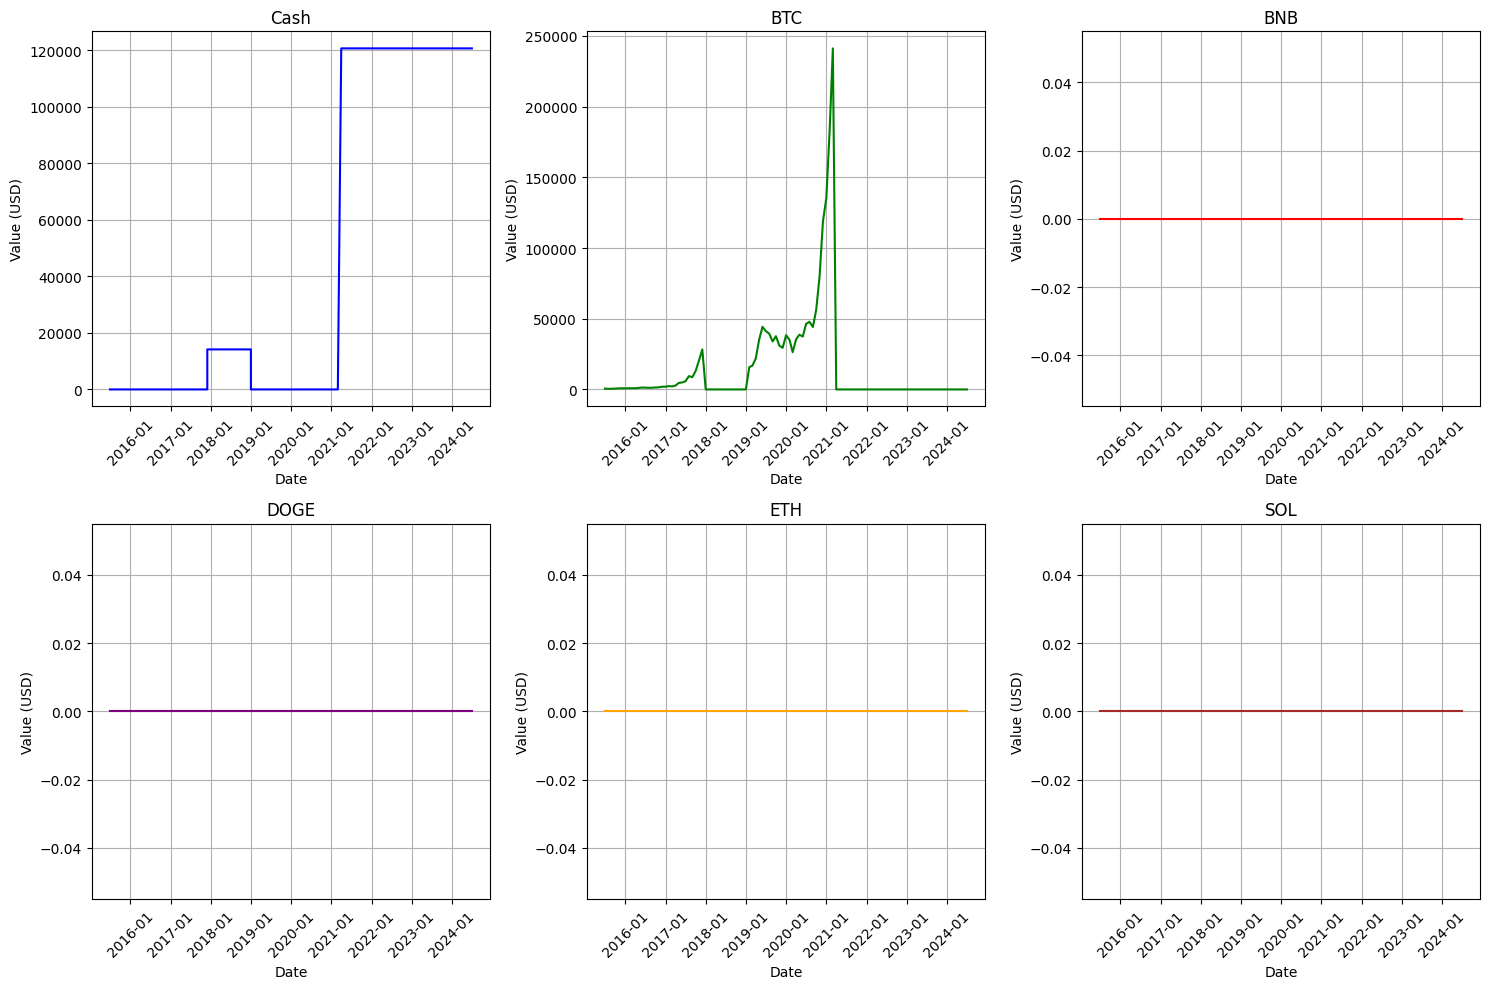

In [84]:
# Get the list of columns excluding the 'Date' column
columns = [col for col in convertedPortfolioHistory.columns if col != "Date"]

convertedPortfolioHistory["Date"] = pd.to_datetime(convertedPortfolioHistory["Date"])


# Define a list of colors for the plots
colors = ["blue", "green", "red", "purple", "orange", "brown"]

# Create a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the 2x3 array of axes for easy iteration
axs = axs.flatten()

# Plot each column in a separate subplot with a different color
for i, column in enumerate(columns):
  axs[i].plot(
    convertedPortfolioHistory["Date"],
    convertedPortfolioHistory[column],
    color=colors[i],
  )
  axs[i].set_title(column)
  axs[i].set_xlabel("Date")
  axs[i].set_ylabel("Value (USD)")
  axs[i].grid(True)

  # Set x-axis ticks at a certain interval
  axs[i].xaxis.set_major_locator(mdates.AutoDateLocator())
  axs[i].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
  axs[i].tick_params(axis="x", rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()